# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [66]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task

# Matplotlib library
import matplotlib.pyplot as plt
from matplotlib import cm

# Numpy library
import numpy as np

from skimage import io
from skimage import img_as_ubyte
from skimage import exposure

Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [67]:
def cont_str(image):
    """
    This function returns a new image with the range of contrast
    stretch from 0-255 which are the lower and upper of an uint8 image.
    
    Parameter
    ---------
    image-  is the image in ubyte format that we want to stretch in its contrast
            range
    """
    contrasted_image=image
    max_value=image.max()
    min_value=image.min()
    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            contrasted_image[i,j]=(image[i,j]-min_value)*((255-0)/(max_value-min_value))        
    return contrasted_image


In [68]:
def print_properties(image):
    """
    A function that prints the shape, type, min value and max value 
    of an image.
    """
    
    print(image.dtype)
    print(image.shape)
    print(image.min())
    print(np.max(image))

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

float64
(691, 1048)
0.56862745098
0.885976862745

uint8
(691, 1048)
145
226

uint8
(691, 1048)
0
243


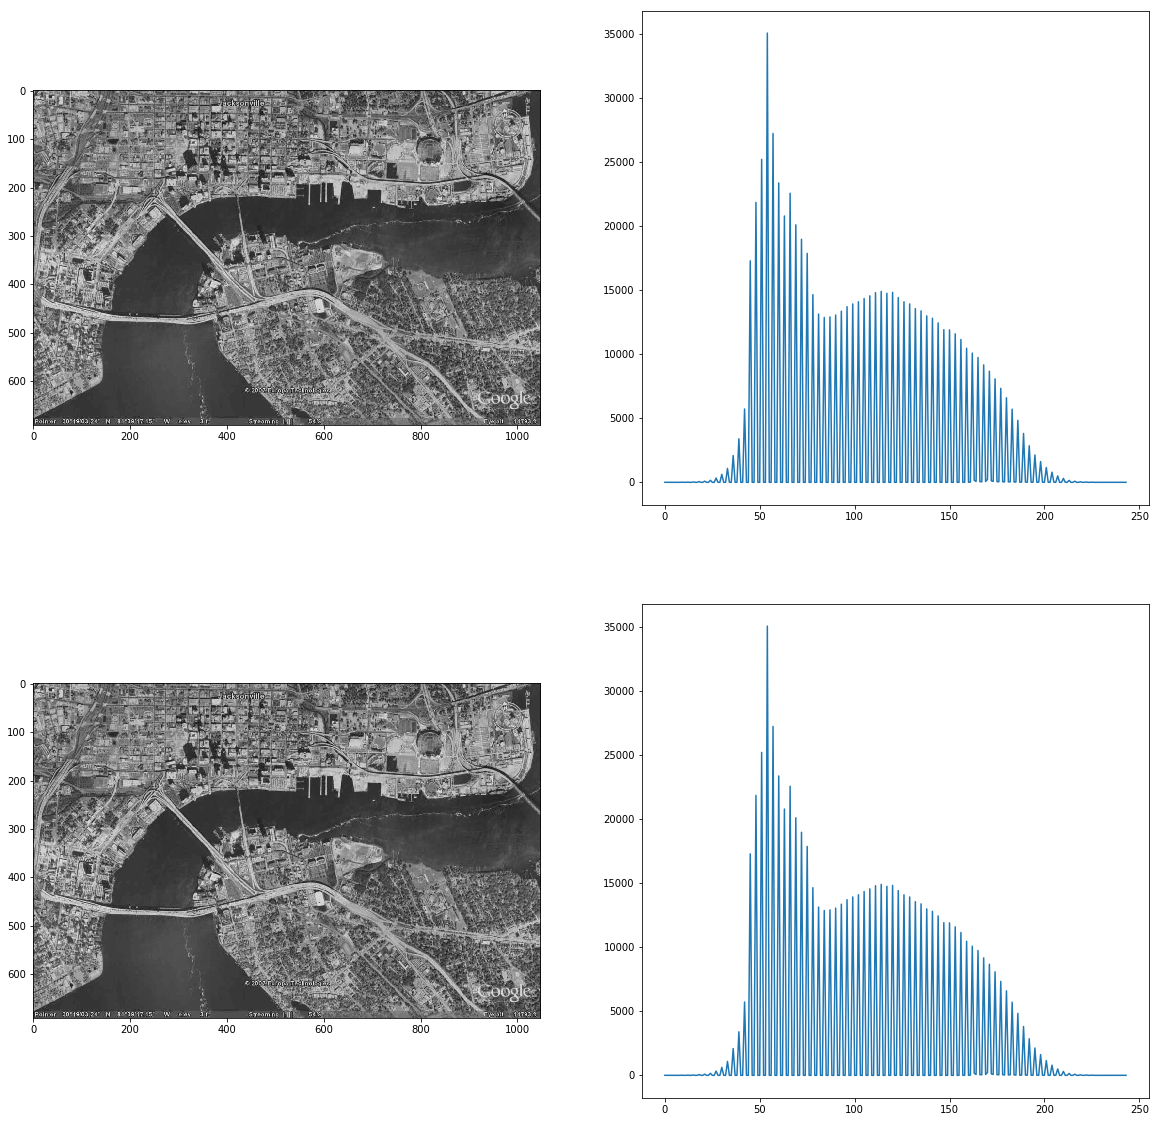

In [74]:
img_path='./images/'
img_name='satellite.jpg'
satellite=io.imread(img_path.__add__(img_name),as_grey=True)
print_properties(satellite)

satellite_ubyte=img_as_ubyte(satellite)
print
print_properties(satellite_ubyte)  # To display the information of the original satellite image

contrasted_satellite=cont_str(satellite_ubyte) # Convert the float64 type image to uint8
print
print_properties(contrasted_satellite)  # Displaying the information of the satellite image

fig , axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()
sate_ub_bins, sate_ub_centers = exposure.histogram(satellite_ubyte)
axes[0].imshow(satellite_ubyte,cmap = cm.gray)
axes[1].plot(sate_ub_centers,sate_ub_bins)

axes[2].imshow(contrasted_satellite,cmap=cm.gray)
sate_ct_bins, sate_ct_centers = exposure.histogram(contrasted_satellite)
axes[3].plot(sate_ct_centers,sate_ct_bins)

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [112]:
def hist_eq(image,min_int, max_int):
    nbr_bins = int(max_int - min_int)
    imhist,bins = np.histogram(image.flatten(),nbr_bins, [min_int,max_int])
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalization
    new_image = np.interp(image.flatten(),bins[:-1],cdf) #To find the new pixels of the values we interpolate
    return new_image.reshape(image.shape) , cdf

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

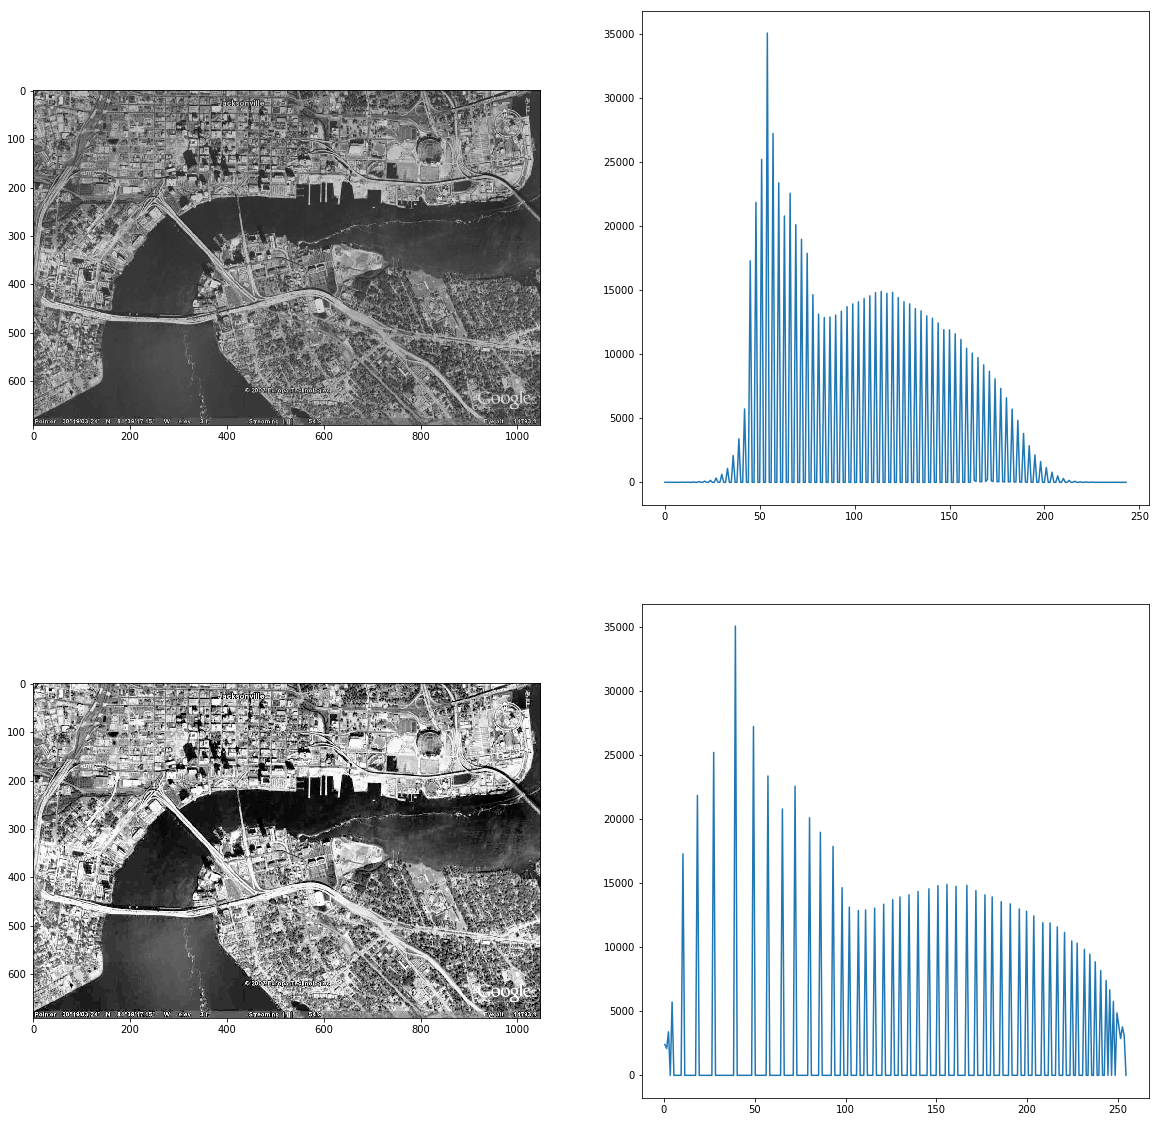

In [113]:
satellite_equalized , cdf_eq = hist_eq(satellite_ubyte,0,256)

fig , axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()
sate_ub_bins, sate_ub_centers = exposure.histogram(satellite_ubyte)
axes[0].imshow(satellite_ubyte,cmap = cm.gray)
axes[1].plot(sate_ub_centers,sate_ub_bins)

axes[2].imshow(satellite_equalized,cmap=cm.gray)
sate_e_bins, sate_e_centers = exposure.histogram(satellite_equalized)
axes[3].plot(sate_e_centers,sate_e_bins)


**Show the transformed image and its histogram**

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

The algortihm of histogram matching makes a transformation of a given image to match another histogram (specified).
The algorithm works like:
- Computing the histogram of reference and target image
- Calculation of the CDF of both histograms 
- Then with the inverse function we can correlate the gray level of every pixel of the original image and create the new one


In [114]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [115]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

243
0


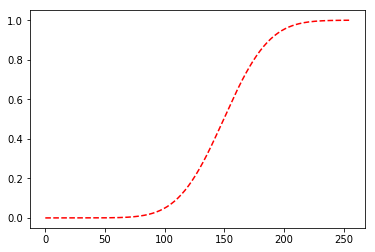

In [116]:
from scipy.stats import norm

max_img = satellite_ubyte.max()
min_img = satellite_ubyte.min()
x = np.arange(256)
pdf_to_fit = norm.pdf(x, 150, 30)
cdf = np.cumsum(pdf_to_fit)
plt.plot(x,cdf,'r--')

print(max_img)
print(min_img)

**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

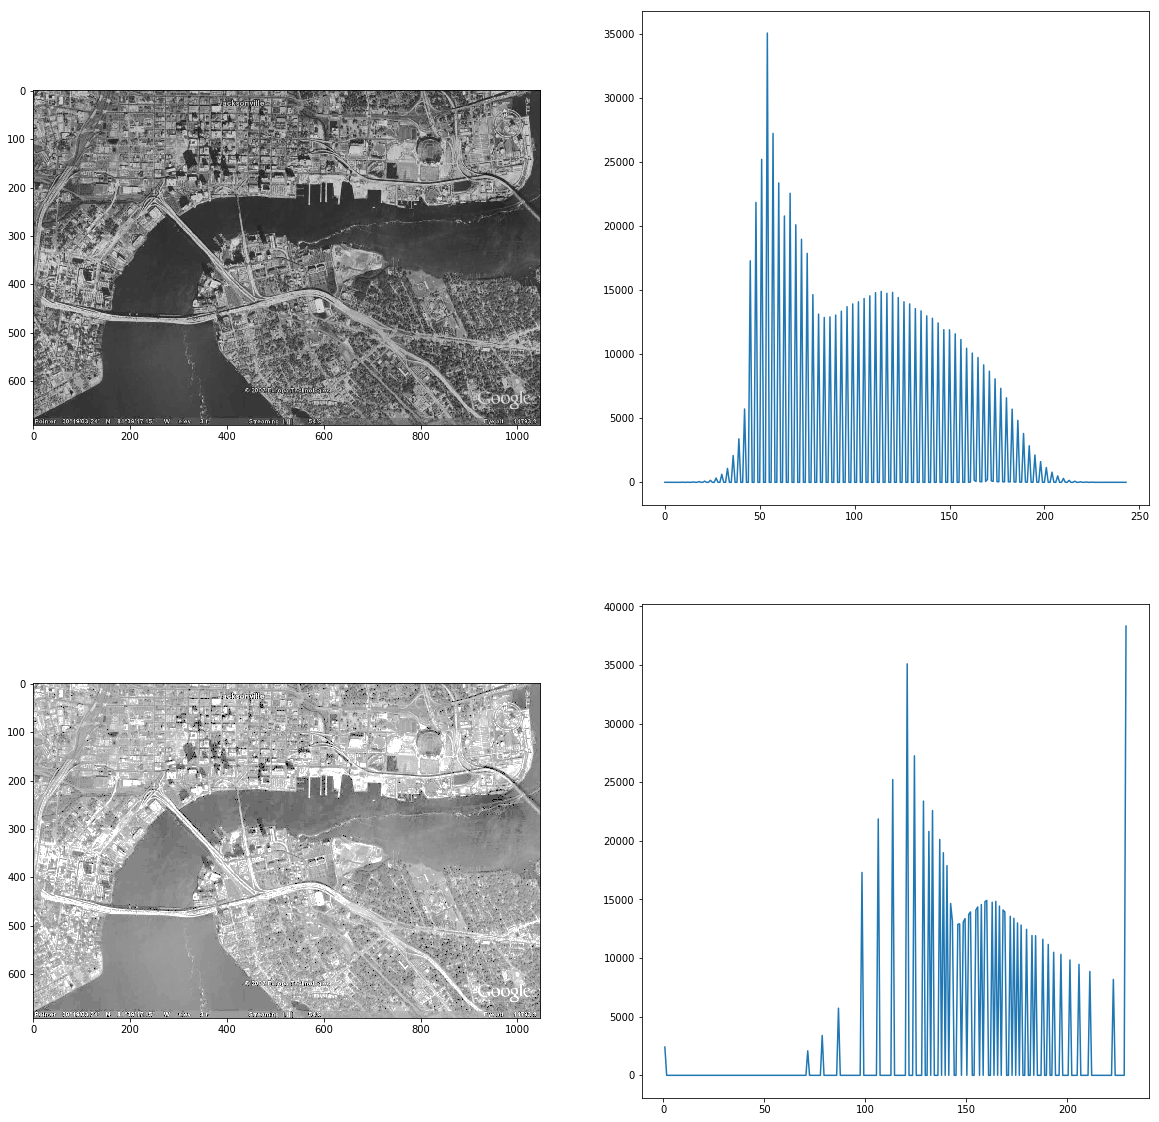

In [117]:
matched_img  = hist_match(satellite_ubyte, pdf_to_fit, min_img, max_img)

fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(20,20))
axes = axes.ravel()

sate_ub_bins, sate_ub_centers = exposure.histogram(satellite_ubyte)
axes[0].imshow(satellite_ubyte,cmap = cm.gray)
axes[1].plot(sate_ub_centers,sate_ub_bins)

axes[2].imshow(matched_img, cmap=cm.gray)
bins, bins_c=np.histogram(matched_img, 256) 
axes[3].plot(bins_c[1:],bins)

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


The purpose of the log transformation is to expand the low intensities pixels of an image, this means that in the trasnformed imagen this pixels will have a wider range of intensity, but this too compress the range of the high intensity pixels of the original image. 
In contrast, with the gamma transform we can get different types of transformations depending of the value of the gamma variable in which if $\gamma$ >1 we use it to dark the high intensity pixels of the original image and if $\gamma$ <1 we use it when the image is to dark and we want to brighten it.

** Explain how sigmoid function enhances the image **

The sigmoid function has a cutoff value that determines the middle point of the "S" shape curve and a gain that determines the "curve" of the graph. With this we can change "drastically" the intensity of the pixels depending on the gain and the distribution of the original histogram, making the low intensity pixels darker than before and the high intesity pixels brigther.